In [1]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv('../backend/.env')

DATABASE_URL = os.getenv("DATABASE_URL")

In [2]:

import psycopg2
from sqlalchemy import create_engine
import sys

print(f"Python version: {sys.version}")

try:
    print("Attempting to import psycopg2...")
    import psycopg2
    print(f"psycopg2 version: {psycopg2.__version__}")
except ImportError as e:
    print(f"Failed to import psycopg2: {e}")
    sys.exit(1)

try:
    import re
    print(f"Attempting to connect with SQLAlchemy to: {re.sub(r':.*@', ':XXX@', DATABASE_URL)}")
    engine = create_engine(DATABASE_URL)
    from sqlalchemy import text
    with engine.connect() as connection:
        result = connection.execute(text("SELECT 1")).fetchone()
        print(f"Connection successful! Result: {result}")
except Exception as e:
    print(f"Connection failed: {e}")


Python version: 3.12.12 (main, Dec  9 2025, 19:02:36) [Clang 21.1.4 ]
Attempting to import psycopg2...
psycopg2 version: 2.9.11 (dt dec pq3 ext lo64)
Attempting to connect with SQLAlchemy to: postgresql+psycopg2:XXX@aws-1-us-east-1.pooler.supabase.com:5432/snake_rivals
Connection successful! Result: (1,)


In [3]:
import prettytable
from prettytable import TableStyle

# Monkeypatch prettytable to support 'PLAIN_COLUMNS' used by ipython-sql
prettytable.PLAIN_COLUMNS = TableStyle.PLAIN_COLUMNS

# Set style and suppress connection/row count output
%config SqlMagic.style = 'PLAIN_COLUMNS'
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False
%load_ext sql
%sql {DATABASE_URL}

%sql select 1 mycolumn

,mycolumn
0,1


In [4]:
%sql SELECT table_name FROM information_schema.tables WHERE table_schema = 'public' ORDER BY table_name;
#%sql SELECT count(table_name) FROM information_schema.tables WHERE table_name  NOT IN ('users', 'groups', 'leaderboard', 'sessions', 'user_groups');

,table_name
0,alembic_version
1,groups
2,leaderboard
3,sessions
4,user_groups
5,users


In [5]:
import pandas as pd
# Improve printing for wide DataFrames
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

In [6]:
# Analyze all tables
tables_to_analyze = ['users', 'groups', 'sessions', 'user_groups', 'leaderboard']

for table in tables_to_analyze:
    print(f"\n{'='*60}")
    print(f"TABLE: {table}")
    print(f"{'='*60}")
    
    # Use ipython-sql variable substitution ($table) to run the queries
    result = %sql SELECT * FROM {table} LIMIT 5
    df_temp = pd.DataFrame(result)
    
    count_res = %sql SELECT COUNT(*) FROM {table}
    row_count = count_res.shape[0]
    print(f"\nRow count: {row_count}")
    print(f"\nSample data (first 5 rows):")
    print(df_temp)
    print(f"\nColumn info:")
    print(df_temp.dtypes)


TABLE: users

Row count: 1

Sample data (first 5 rows):
                                     id username                          email hashed_password
0  a1ecbe32-6c0e-4fb9-8349-664b69de1076      dad             znyiri@hotmail.com          dad123
1  76981e1a-709c-4fbe-953f-a55de590c483      pat        patriknyiri13@gmail.com          pat123
2  cb0394a9-9c7e-4fb1-9027-d9e0e5ae9a6a    sofia            snyiri100@gmail.com        sofia123
3  e0ca4a46-d48a-4020-809b-0b882dbf347f    chris  christopher.nyiri@hotmail.com        chris123
4  1407510a-71b7-4fa6-81f1-d7d67da8de1b      mom         barbpinter@fastmail.fm          mom123

Column info:
id                 object
username           object
email              object
hashed_password    object
dtype: object

TABLE: groups

Row count: 1

Sample data (first 5 rows):
                                     id       name
0  56bcb262-4934-4abe-9eca-cb15753db301       test
1  5b05fe5c-626c-439b-910c-a0a08bf2a411     family
2  9fffed99-98c0-4559-a2

In [14]:
df = %sql select * from leaderboard

# Convert ResultSet to DataFrame
df_pandas = pd.DataFrame(df)
df_pandas.columns = ['id', 'username', 'score', 'game', 'created_at', 'user_id']

# Display basic information
print("Dataset Overview:")
print(f"Total records: {len(df_pandas)}")
print(f"\nColumn types:\n{df_pandas.dtypes}")
print(f"\nBasic statistics:\n{df_pandas.describe()}")
print(f"\nUnique games: {df_pandas['game'].unique()}")
print(f"\nUnique players: {df_pandas['username'].unique()}")
print(f"\nScores by game:\n{df_pandas.groupby('game')['score'].agg(['count', 'mean', 'max', 'min'])}")
print(f"\nTop scores by player:\n{df_pandas.groupby('username')['score'].max().sort_values(ascending=False)}")

Dataset Overview:
Total records: 107

Column types:
id                         object
username                   object
score                       int64
game                       object
created_at    datetime64[ns, UTC]
user_id                    object
dtype: object

Basic statistics:
             score
count   107.000000
mean    223.327103
std     534.529449
min       0.000000
25%      20.000000
50%      70.000000
75%     163.000000
max    4190.000000

Unique games: ['tetris' 'space_invaders' 'snake' 'minesweeper']

Unique players: ['dad' 'andrew' 'pat' 'mom' 'chris']

Scores by game:
                count        mean   max  min
game                                        
minesweeper        20  426.500000  1900    0
snake              64   83.906250   500    0
space_invaders     14   80.000000   170    0
tetris              9  986.222222  4190  166

Top scores by player:
username
mom       4190
dad       2300
pat        780
andrew     330
chris       90
Name: score, dtype: int64


In [8]:
df_pandas.shape

(107, 6)

In [9]:
print("="*60)
print("5. LEADERBOARD - ADVANCED ANALYSIS")
print("="*60)

# Already have leaderboard data in df_pandas
print("\n📊 Game Statistics:")
print(df_pandas.groupby('game').agg({
    'score': ['count', 'mean', 'median', 'max', 'min', 'std']
}).round(2))

print("\n🏆 Top 10 Scores Overall:")
print(df_pandas.nlargest(10, 'score')[['username', 'game', 'score', 'created_at']])

print("\n👥 Player Performance:")
print(df_pandas.groupby('username').agg({
    'score': ['count', 'mean', 'max'],
    'game': 'nunique'
}).round(2))

print("\n🎮 Games Played per Player:")
print(df_pandas.groupby('username')['game'].value_counts().unstack(fill_value=0))

5. LEADERBOARD - ADVANCED ANALYSIS

📊 Game Statistics:
               score                                   
               count    mean median   max  min      std
game                                                   
minesweeper       20  426.50  195.0  1900    0   581.18
snake             64   83.91   50.0   500    0   102.15
space_invaders    14   80.00   75.0   170    0    51.29
tetris             9  986.22  196.0  4190  166  1395.62

🏆 Top 10 Scores Overall:
   username         game  score                       created_at
23      mom       tetris   4190 2025-12-09 21:22:09.288682+00:00
31      dad       tetris   2300 2025-12-06 18:04:53.861617+00:00
32      mom  minesweeper   1900 2025-12-09 21:02:51.970562+00:00
99      mom  minesweeper   1900 2025-12-09 21:05:26.987301+00:00
22      mom       tetris   1082 2025-12-09 21:11:33.493347+00:00
37      pat  minesweeper    780 2025-12-19 12:47:23.003447+00:00
57      pat  minesweeper    720 2025-12-19 12:47:55.259179+00:00
70     

In [10]:
df_pandas

,id,username,score,game,created_at,user_id
0,07b5b5fd-6e85-49c5-9335-4c7e93b655cf,dad,182,tetris,2025-12-21 14:50:49.758341+00:00,a1ecbe32-6c0e-4fb9-8349-664b69de1076
1,53d36322-f5bf-4506-a7e0-6ead1f81329a,dad,70,space_invaders,2025-12-22 11:08:24.763111+00:00,a1ecbe32-6c0e-4fb9-8349-664b69de1076
2,1385b0ee-225e-4073-b068-e2fca954d8cf,dad,90,space_invaders,2025-12-21 15:07:21.469778+00:00,a1ecbe32-6c0e-4fb9-8349-664b69de1076
3,ae93b417-0c8f-4d95-bfd4-d1bfb65d798f,dad,180,tetris,2025-12-22 14:08:15.477523+00:00,a1ecbe32-6c0e-4fb9-8349-664b69de1076
4,4c16abbb-9b7c-4a7d-bd5b-11cd029fb430,dad,0,snake,2025-12-03 20:10:54.038615+00:00,a1ecbe32-6c0e-4fb9-8349-664b69de1076
...,...,...,...,...,...,...
102,2ca34c81-3607-4574-a9c8-9bacfe6e0c49,dad,30,snake,2025-12-09 23:24:10.001064+00:00,a1ecbe32-6c0e-4fb9-8349-664b69de1076
103,abe2d895-77d8-45a3-8902-518412eed949,dad,20,snake,2025-12-16 17:42:39.615615+00:00,a1ecbe32-6c0e-4fb9-8349-664b69de1076
104,63ee299a-14c0-4609-8f55-66f654440355,dad,170,space_invaders,2025-12-16 17:44:39.228974+00:00,a1ecbe32-6c0e-4fb9-8349-664b69de1076
105,87cdaf0a-6dfd-4845-ba33-43234865bad7,dad,20,snake,2025-12-21 12:01:59.171342+00:00,a1ecbe32-6c0e-4fb9-8349-664b69de1076


In [11]:
print("="*60)
print("🏅 RANKINGS BY GAME")
print("="*60)

# Calculate rank for each game based on highest score
for game in df_pandas['game'].unique():
    game_data = df_pandas[df_pandas['game'] == game].copy()
    
    # Get best score per player for this game
    best_scores = game_data.groupby('username')['score'].max().reset_index()
    best_scores['rank'] = best_scores['score'].rank(ascending=False, method='min').astype(int)
    best_scores = best_scores.sort_values('rank')
    
    print(f"\n🎮 {game.upper()} Rankings:")
    print("-" * 40)
    for idx, row in best_scores.iterrows():
        medal = "🥇" if row['rank'] == 1 else "🥈" if row['rank'] == 2 else "🥉" if row['rank'] == 3 else "  "
        print(f"  {medal} #{row['rank']} - {row['username']:10s} - {row['score']:5.0f} points")

print("\n" + "="*60)
print("🏆 OVERALL CHAMPION - Best Score Across All Games")
print("="*60)
overall_best = df_pandas.nlargest(1, 'score').iloc[0]
print(f"\n🏆 {overall_best['username'].upper()} - {overall_best['score']:.0f} points in {overall_best['game']}!")

print("\n" + "="*60)
print("👑 GAME CHAMPIONS - Top Player in Each Game")
print("="*60)
for game in sorted(df_pandas['game'].unique()):
    game_best = df_pandas[df_pandas['game'] == game].nlargest(1, 'score').iloc[0]
    print(f"  {game:15s} - {game_best['username']:10s} ({game_best['score']:.0f} points)")

🏅 RANKINGS BY GAME

🎮 TETRIS Rankings:
----------------------------------------
  🥇 #1 - mom        -  4190 points
  🥈 #2 - dad        -  2300 points

🎮 SPACE_INVADERS Rankings:
----------------------------------------
  🥇 #1 - dad        -   170 points
  🥈 #2 - pat        -   150 points
  🥉 #3 - andrew     -   100 points
     #4 - mom        -    90 points
     #5 - chris      -    50 points

🎮 SNAKE Rankings:
----------------------------------------
  🥇 #1 - pat        -   500 points
  🥈 #2 - dad        -   360 points
  🥉 #3 - mom        -   120 points
     #4 - chris      -    90 points
     #5 - andrew     -    70 points

🎮 MINESWEEPER Rankings:
----------------------------------------
  🥇 #1 - mom        -  1900 points
  🥈 #2 - pat        -   780 points
  🥉 #3 - dad        -   570 points
     #4 - andrew     -   330 points

🏆 OVERALL CHAMPION - Best Score Across All Games

🏆 MOM - 4190 points in tetris!

👑 GAME CHAMPIONS - Top Player in Each Game
  minesweeper     - mom        (19

📊 RANKING SUMMARY & VISUALIZATION

🎯 Scoring System: Reverse Rank (1st=5pts, 2nd=4pts, ...)
   (Based on 5 total players)

🏆 Championship Standings:
username  points  position
     dad      16         1
     mom      15         2
     pat      13         3
  andrew       6         4
   chris       3         5


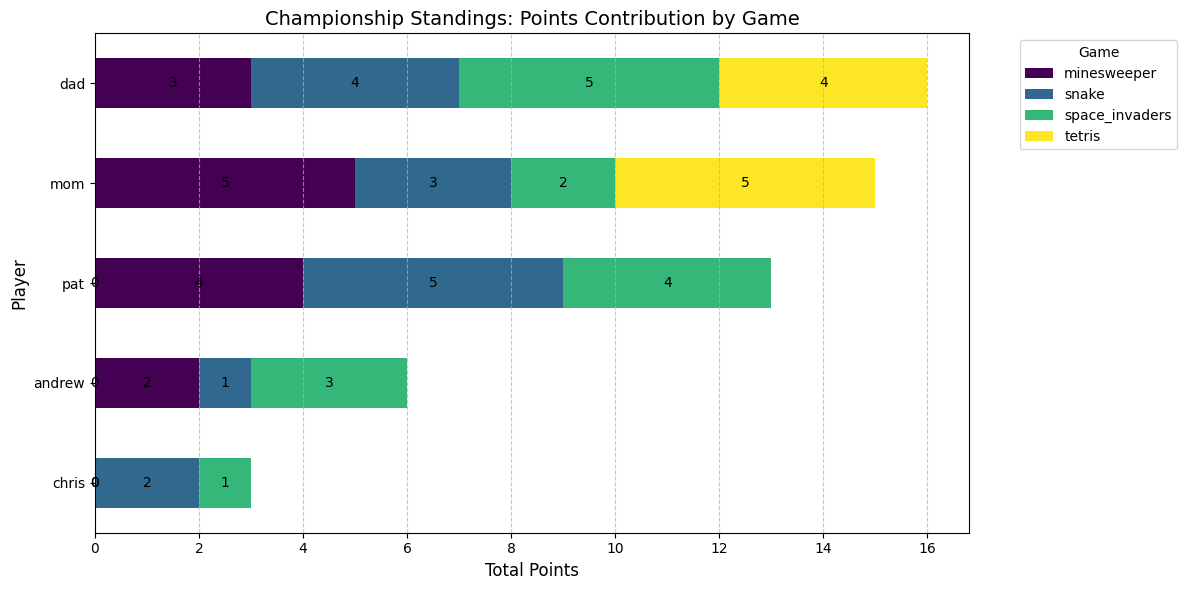


🎉 OVERALL CHAMPION: DAD!


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

print("="*60)
print("📊 RANKING SUMMARY & VISUALIZATION")
print("="*60)

# 1. Calculate Rankings
ranking_summary = []
for game in sorted(df_pandas['game'].unique()):
    game_data = df_pandas[df_pandas['game'] == game].copy()
    # Get best score per player for this game
    best_scores = game_data.groupby('username')['score'].max().reset_index()
    # Rank: 1 is best. method='min' means ties get same rank (e.g. 1, 1, 3)
    best_scores['rank'] = best_scores['score'].rank(ascending=False, method='min').astype(int)
    best_scores['game'] = game
    ranking_summary.append(best_scores[['game', 'rank', 'username', 'score']])

all_rankings = pd.concat(ranking_summary, ignore_index=True)

# 2. Improved Points System
# Dynamic scoring based on number of players
# 1st place gets N points, 2nd gets N-1, etc. (where N = total unique players)
# This ensures everyone gets at least 1 point for participating
unique_players = df_pandas['username'].unique()
num_players = len(unique_players)
print(f"\n🎯 Scoring System: Reverse Rank (1st={num_players}pts, 2nd={num_players-1}pts, ...)")
print(f"   (Based on {num_players} total players)")

def calculate_points(rank):
    # If rank is 1, points = 5. If rank is 5, points = 1.
    return max(1, num_players - rank + 1)

all_rankings['points'] = all_rankings['rank'].apply(calculate_points)

# 3. Calculate Championship Standings
championship_standings = all_rankings.groupby('username')['points'].sum().sort_values(ascending=False).reset_index()
championship_standings['position'] = range(1, len(championship_standings) + 1)

print("\n🏆 Championship Standings:")
print(championship_standings.to_string(index=False))

# 4. Visualization
# Prepare data for stacked bar chart (Points per game per player)
pivot_points = all_rankings.pivot(index='username', columns='game', values='points').fillna(0)

# Sort by total points for the plot
pivot_points['Total'] = pivot_points.sum(axis=1)
pivot_points = pivot_points.sort_values('Total', ascending=True)
pivot_points = pivot_points.drop('Total', axis=1)

# Create Plot
plt.figure(figsize=(12, 6))
pivot_points.plot(kind='barh', stacked=True, ax=plt.gca(), colormap='viridis')

plt.title('Championship Standings: Points Contribution by Game', fontsize=14)
plt.xlabel('Total Points', fontsize=12)
plt.ylabel('Player', fontsize=12)
plt.legend(title='Game', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add value labels
for c in plt.gca().containers:
    plt.gca().bar_label(c, label_type='center', fmt='%.0f')

plt.tight_layout()
plt.show()

champion = championship_standings.iloc[0]['username']
print(f"\n🎉 OVERALL CHAMPION: {champion.upper()}!")

In [13]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display

print("="*60)
print("🕸️ INTERACTIVE SPIDER WEB CHART")
print("="*60)

# Get list of players for selection
available_players = sorted(df_pandas['username'].unique())

def plot_player_performance(player_name):
    # 1. Prepare Data
    all_games = sorted(df_pandas['game'].unique())
    player_data = all_rankings[all_rankings['username'] == player_name]

    ranks = []
    for game in all_games:
        row = player_data[player_data['game'] == game]
        if not row.empty:
            ranks.append(row.iloc[0]['rank'])
        else:
            # If not played, assign a rank lower than the last place (e.g., num_players + 1)
            ranks.append(num_players + 1)

    # Calculate Average Rank
    avg_rank = np.mean(ranks)

    # 2. Setup Radar Chart
    N = len(all_games)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1] # Close the loop
    
    ranks_plot = ranks + ranks[:1] # Close the loop

    # 3. Plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], [g.upper() for g in all_games], size=12)
    
    # Draw ylabels
    worst_rank = num_players + 1
    plt.ylim(0, worst_rank)
    plt.yticks(range(1, worst_rank), map(str, range(1, worst_rank)), color="grey", size=10)
    ax.set_rlabel_position(0)
    
    # Plot data
    ax.plot(angles, ranks_plot, linewidth=2, linestyle='solid', label=player_name.upper(), color='blue')
    ax.fill(angles, ranks_plot, 'b', alpha=0.1)
    
    # INVERT the radial axis so 1 is OUTSIDE and worst_rank is INSIDE
    ax.set_rlim(worst_rank, 0)
    
    plt.title(f"Performance Profile: {player_name.upper()}\nAvg Rank: {avg_rank:.1f} (Outer is Better #1)", size=16, y=1.08)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

# Create interactive widget
print("Select a player to view their performance profile:")
%matplotlib inline
# Use a safe default (first available player) and fall back if list is empty
if available_players:
    widgets.interact(plot_player_performance, player_name=widgets.Dropdown(options=available_players, description='Player:', value=available_players[0]));
else:
    print('No players available to plot.')

🕸️ INTERACTIVE SPIDER WEB CHART
Select a player to view their performance profile:


interactive(children=(Dropdown(description='Player:', options=('andrew', 'chris', 'dad', 'mom', 'pat'), value=…